<a href="https://colab.research.google.com/github/marcelo-custodio/Federated_Stress_Detector/blob/main/teste_ae_centralizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc

# Reprodutibilidade básica
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [70]:
DATA_PATH = "creditcard.csv"
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
display(df['Class'].value_counts())


Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


,count
Class,
0,284315
1,492


In [71]:
df = df.copy()
df = df.drop(columns=['Time'])

cols = [c for c in df.columns if c != 'Class'] + ['Class']
df = df[cols]

# Separar X e y
X = df.drop(columns=['Class'])
y = df['Class'].values

print("X shape:", X.shape)
print("Fraud ratio:", y.sum() / len(y))


X shape: (284807, 29)
Fraud ratio: 0.001727485630620034


In [72]:
X_norm = X[y == 0]
X_fraud = X[y == 1]
X_norm_train, X_norm_valtest = train_test_split(X_norm, test_size=0.2, random_state=SEED)

# Escalar Amount
scaler_amount = StandardScaler()
X_norm_train['Amount_scaled'] = scaler_amount.fit_transform(X_norm_train[['Amount']])
X_norm_train = X_norm_train.drop(columns=['Amount'])

X_norm_valtest['Amount_scaled'] = scaler_amount.transform(X_norm_valtest[['Amount']])
X_norm_valtest = X_norm_valtest.drop(columns=['Amount'])

# Escalar Time
### scaler_time = StandardScaler()
### X_norm_train['Time_scaled'] = scaler_time.fit_transform(X_norm_train[['Time']])
### X_norm_train = X_norm_train.drop(columns=['Time'])

### X_norm_valtest['Time_scaled'] = scaler_time.transform(X_norm_valtest[['Time']])
### X_norm_valtest = X_norm_valtest.drop(columns=['Time'])

# Construir conjunto de teste: pegar X_norm_valtest + todas fraudes
X_test = np.vstack([X_norm_valtest, X_fraud])
y_test = np.hstack([np.zeros(len(X_norm_valtest), dtype=int), np.ones(len(X_fraud), dtype=int)])

# Também separar uma validação somente de normais para monitoramento
X_val = X_norm_valtest

print("Train (somente normais):", X_norm_train.shape)
print("Val (normais):", X_val.shape)
print("Test (normais + fraudes):", X_test.shape, "   Frauds in test:", y_test.sum())


Train (somente normais): (227452, 29)
Val (normais): (56863, 29)
Test (normais + fraudes): (57355, 29)    Frauds in test: 492


In [73]:
input_dim = X.shape[1]
reg_l2 = 1e-4
dropout_rate = 0.2

inp = layers.Input(shape=(input_dim,))

# Encoder
x = layers.Dense(128, activation=None,
                 kernel_regularizer=regularizers.l2(reg_l2))(inp)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(dropout_rate)(x)

x = layers.Dense(64, activation=None,
                 kernel_regularizer=regularizers.l2(reg_l2))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(dropout_rate)(x)

latent = layers.Dense(16, activation=None,
                      kernel_regularizer=regularizers.l2(reg_l2),
                      name="latent_space")(x)
latent = layers.BatchNormalization()(latent)
latent = layers.ReLU()(latent)

# Decoder
x = layers.Dense(64, activation=None,
                 kernel_regularizer=regularizers.l2(reg_l2))(latent)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(dropout_rate)(x)

x = layers.Dense(128, activation=None,
                 kernel_regularizer=regularizers.l2(reg_l2))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(dropout_rate)(x)

out = layers.Dense(input_dim, activation='linear')(x)

autoencoder = models.Model(inp, out, name='deep_autoencoder')
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss='mse')
autoencoder.summary()

Model: "deep_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,885 (108.93 KB)

 Trainable params: 27,085 (105.80 KB)

 Non-trainable params: 800 (3.12 KB)

In [74]:
EPOCHS = 100
BATCH = 1024

es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = autoencoder.fit(
    X_norm_train, X_norm_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[es]
)


Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 1.1007 - val_loss: 0.4599
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.5493 - val_loss: 0.3201
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.4577 - val_loss: 0.2736
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.4119 - val_loss: 0.2469
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.3841 - val_loss: 0.2229
Epoch 6/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3607 - val_loss: 0.2090
Epoch 7/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.3444 - val_loss: 0.1963
Epoch 8/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.3317 - val_loss: 0.1916
Epoch 9/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.3204 - val_loss: 0.1778
Epoch 10/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.3119 - val_loss: 0.1691
Epoch 11/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.3037 - val_loss: 0.1651
Epoch 12/100
223/223 ━━━━━━━━

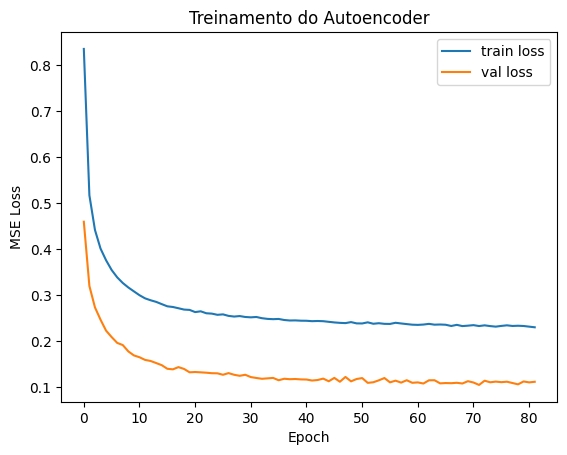

In [75]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Treinamento do Autoencoder')
plt.show()


1793/1793 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


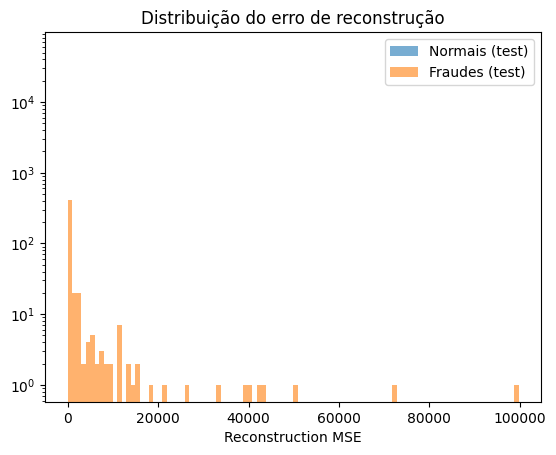

In [76]:
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - X_test_pred), axis=1)

# visualizar distribuições de MSE para normais x fraudes
mse_norm = mse[y_test == 0]
mse_fraud = mse[y_test == 1]

plt.hist(mse_norm, bins=100, alpha=0.6, label='Normais (test)')
plt.hist(mse_fraud, bins=100, alpha=0.6, label='Fraudes (test)')
plt.yscale('log')
plt.legend()
plt.xlabel('Reconstruction MSE')
plt.title('Distribuição do erro de reconstrução')
plt.show()


In [82]:
threshold = np.percentile(mse_norm, 95)
print("Threshold (95 percentile of normal MSE):", threshold)

y_pred = (mse > threshold).astype(int)

# Métricas
auc_score = roc_auc_score(y_test, mse)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("AUC (usando MSE scores):", auc_score)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print("Confusion Matrix (rows=true, cols=pred):\n", cm)


Threshold (95 percentile of normal MSE): 0.27199156853145096
AUC (usando MSE scores): 0.9894585817373921
Precision: 0.1431, Recall: 0.9654, F1: 0.2493
Confusion Matrix (rows=true, cols=pred):
 [[54019  2844]
 [   17   475]]


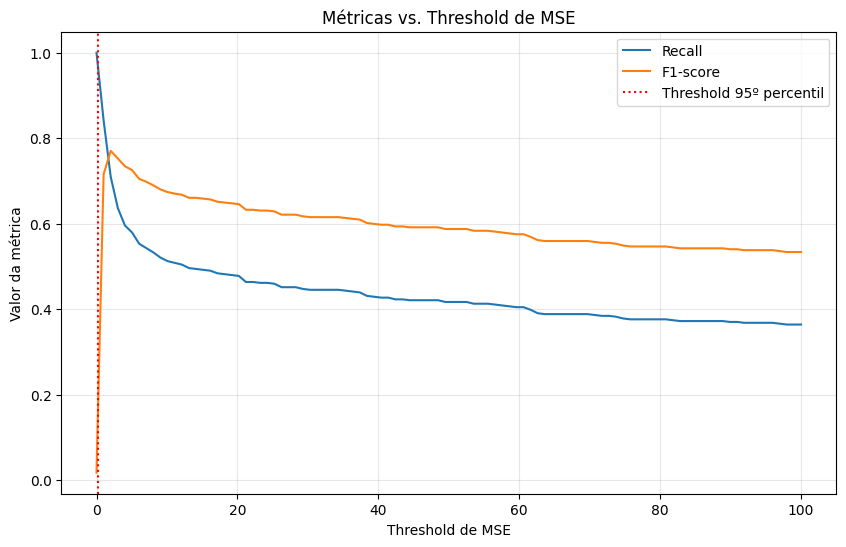

In [83]:
# Definir uma faixa de thresholds
thresholds = np.linspace(100*(np.min(mse)/np.max(mse)), 100, 100)

# Listas para armazenar métricas
auc_scores = []
precisions = []
recalls = []
f1_scores = []

# Calcular métricas para cada threshold
for t in thresholds:
    y_pred = (mse > t).astype(int)

    # AUC: calculada diretamente sobre os valores de MSE
    auc_score = roc_auc_score(y_test, mse)

    # Outras métricas: dependem do threshold
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)

    auc_scores.append(auc_score)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Plotar
plt.figure(figsize=(10,6))
# plt.plot(thresholds, auc_scores, label='AUC', linestyle='--', color='black')
# plt.plot(thresholds, precisions, label='Precisão')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score')

plt.axvline(np.percentile(mse[y_test == 0], 95), color='red', linestyle=':', label='Threshold 95º percentil')

plt.title('Métricas vs. Threshold de MSE')
plt.xlabel('Threshold de MSE')
plt.ylabel('Valor da métrica')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

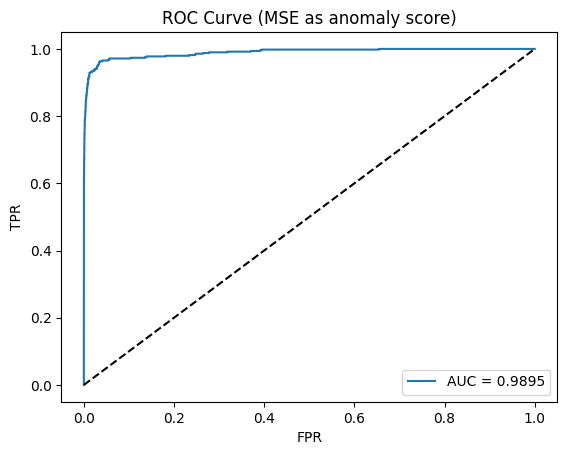

In [84]:
fpr, tpr, _ = roc_curve(y_test, mse)
roc_auc_score_value = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score_value:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve (MSE as anomaly score)')
plt.legend()
plt.show()